#**ECE 421 ASSIGNMENT 1** 
By Valentina Manferrari

Student ID: 1004796615

Link to the Google Colab document: https://colab.research.google.com/drive/1_sPMuESSPLOJbUpt4KiQ7wAFHtKOCqOU?usp=sharing




In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/ECE421/A1/ECE421_A1_code_manferrari.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/ECE421/A1/ECE421_A1_code_manferrari.ipynb to html
[NbConvertApp] Writing 1153918 bytes to /content/drive/MyDrive/ECE421/A1/ECE421_A1_code_manferrari.html


# 1. Logistic Regression with Numpy

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.compat.v1.placeholder
tf.compat.v1.reset_default_graph

Instructions for updating:
non-resource variables are not supported in the long term


<function tensorflow.python.framework.ops.reset_default_graph>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib as mat

def loadData():
    with np.load('notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


###1. Loss Function and Gradient



In [3]:
# Defining the sigmoid as an helper function 
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [4]:
def loss(W, b, x, y, reg):
    # the np.matmul function is used for matrix multiplication
    z = np.matmul(x,W) + b
    Y = sigmoid(z)

    # total_loss = cross-entropy_loss + regularizarion_term
    # np.sum return the sum of array elements over a given axis
    # np.shape function returns a tuple with each index having the number of corresponding elements (we only need index 0)
    loss_CE = np.sum(-(y*np.log(Y))-(1-y)*np.log(1-Y))/np.shape(y)[0]
    loss_w = reg/2 * np.sum(W*W) # reg = lambda
    
    total_loss = loss_CE + loss_w
    return total_loss

In [5]:
def grad_loss(W, b, x, y, reg):
  z = np.matmul(x,W) + b
  Y = sigmoid(z)

  #calculating the loss gradient with respect to the weights
  grad_w = np.matmul(np.transpose(x), (Y-y))/np.shape(y)[0]
  #calculating the loss gradient with respect to the bias
  grad_b = np.sum(Y-y)/np.shape(y)[0]

  return grad_w, grad_b # function returns a tuple with each value as an element

###2. Gradient Descent Implementation



In [6]:
# grad_descent takes as arguments the weight vector W, the bias b, the data matrix x,
# the labels vector y, the learning rate alpha, the number of epochs, 
# the lambda parameter (reg), error tolerance error_tol = 1*10^(-7) 
# and extraInfo that contains the validation dataset paramenters
def grad_descent(W, b, x, y, alpha, epochs, reg, error_tol, extraInfo):
    
    # These variables are necessary for plotting the graphs
    train_err = loss(W, b, x, y, reg)
    val_err = loss(W, b, extraInfo[1], extraInfo[4], reg)
    test_err = loss(W, b, extraInfo[2], extraInfo[5], reg)
    train_acc = accuracy(W, b, x, y)
    val_acc = accuracy(W, b, extraInfo[1], extraInfo[4])
    test_acc = accuracy(W, b, extraInfo[2], extraInfo[5])
    # --- end of definition ---

    weights = W
    bias = b
    # Gradient Descent Algorithm
    for i in range(epochs-1):
      gradLoss_w_b = grad_loss(weights, bias, x, y, reg)
      updated_w = weights - alpha*gradLoss_w_b[0]
      updated_b = bias - alpha*gradLoss_w_b[1]
      magnitude = np.linalg.norm(updated_w - weights)
      if (magnitude < error_tol):
        return updated_w, updated_b
      else:
        weights = updated_w
        bias = updated_b
      # --- end of algorithm implementation ---

      # updating variables with new values every 10 epoches
      # this choice was made because sampling makes graph plotting quicker but still accurate enough 
      #if (i % 10 == 0):
      train_err = np.append(train_err, loss(weights, bias, x, y, reg))
      val_err = np.append(val_err, loss(weights, bias, extraInfo[1], extraInfo[4], reg))
      test_err = np.append(test_err, loss(weights, bias, extraInfo[2], extraInfo[5], reg))
      train_acc = np.append(train_acc, accuracy(weights, bias, x, y))
      val_acc = np.append(val_acc, accuracy(weights, bias, extraInfo[1], extraInfo[4]))
      test_acc = np.append(test_acc, accuracy(weights, bias, extraInfo[2], extraInfo[5]))
    
    # plotting error and accuracy over epoches for training, validation and test datatsets
    plot(train_err, val_err, test_err, accuracy(weights, bias, extraInfo[2], extraInfo[5]), 
         alpha, reg, "Error")
    plot(train_acc, val_acc, test_acc, accuracy(weights, bias, extraInfo[2], extraInfo[5]), 
         alpha, reg, "Accuracy")
    
    return weights, bias

### 3. Tuning the Learning Rate

In [7]:
def plot(training, validation, testing, test, alpha, reg, error_flag):
  plt.figure()
  plt.plot(training, label="Training")
  plt.plot(validation, label="Validation")
  plt.plot(testing, label="Testing")

  # Formatting graph
  title = " Logistic Regression with Numpy\n Learning rate = %.4f and regularization = %.3f \n" %(alpha, reg) +\
  "Final Test Accuracy: " + "%.2f" %(test*100) + "%"

  plt.title(title)
  plt.xlabel("Epochs")
  if(error_flag == "Error"):
    plt.ylabel("Error")
  elif(error_flag == "Accuracy"):
    plt.ylabel("Accuracy")
  plt.legend(loc="best")
  plt.grid()
  plt.draw()
  return

In [8]:
def accuracy(W, b, x, y):
    z = np.matmul(x, W) + b
    Y = sigmoid(z)
    Y = np.around(Y)
    Y = Y.astype(bool)
    accuracy = 1-(np.count_nonzero(y - Y)/len((y - Y)))
    return accuracy

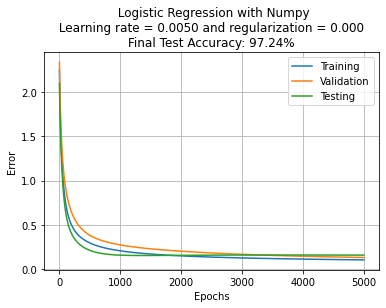

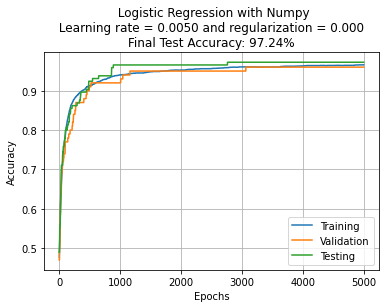

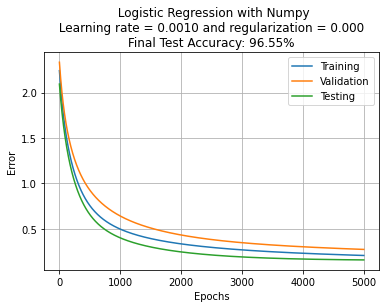

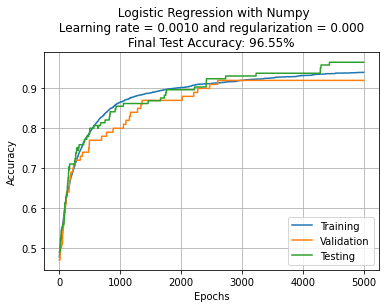

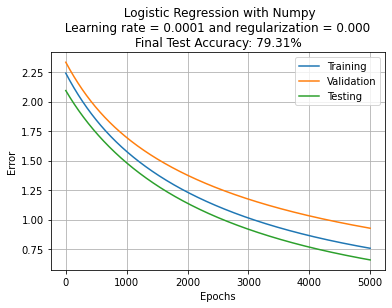

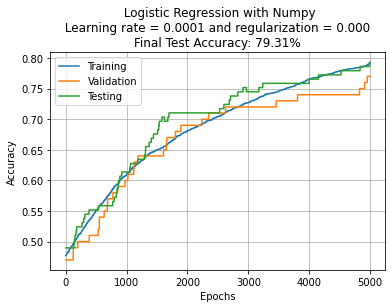

In [9]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(trainData.shape[0], -1)
validData = validData.reshape(validData.shape[0], -1)
testData = testData.reshape(testData.shape[0], -1)
allData = [trainData, validData, testData, trainTarget, validTarget, testTarget]
W = np.random.normal(0, 0.5, (784, 1))  # to normlize we set mean = 0 and standard_deviation = 0.5
b = np.random.normal(0, 0.5, 1)

error_tol = 10**(-7)
epochs = 5000
alpha = [0.005, 0.001, 0.0001]
reg = 0

for a in alpha:
  train_w, train_b = grad_descent(W, b, trainData, trainTarget, a, epochs, reg, error_tol, allData)
  plt.show()

### 4. Generalization

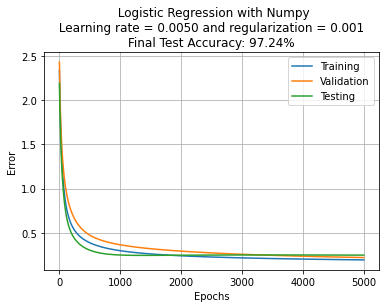

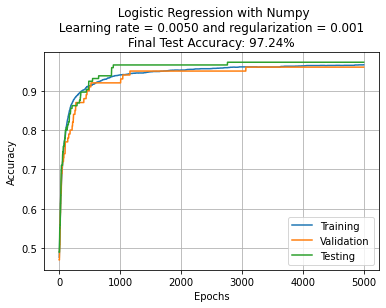

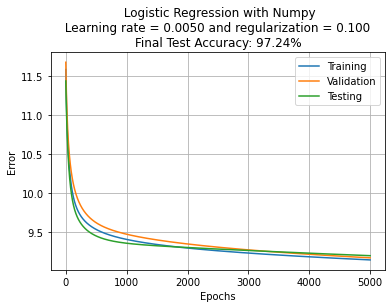

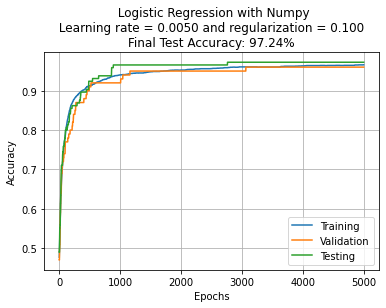

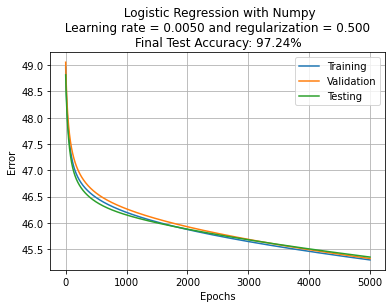

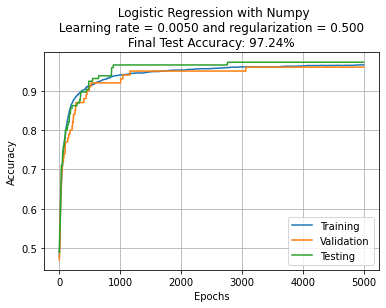

In [10]:
reg = [0.001, 0.1, 0.5]
alpha = 0.005
for Lambda in reg:
  train_w, train_b = grad_descent(W, b, trainData, trainTarget, alpha, epochs, Lambda, error_tol, allData)
  plt.show()

# 2. Logistic Regression in TensorFlow

### 1. Building the Computational Graph

In [28]:
def accuracy(predictions, labels):
    return (np.sum((predictions>=0.5)==labels) / np.shape(predictions)[0])

def buildGraph(beta1=None, beta2=None, epsilon=None, Lambda = 0, alpha=0.001, batch_size = 100, epochs = 700):
    tf.set_random_seed(421)
    tf.reset_default_graph()
    g = tf.Graph()
    with g.as_default():
        # Step A: defining the weight and bias tensor
        W = tf.Variable(tf.truncated_normal(shape=(784, 1), mean=0.0, stddev=0.5, dtype=tf.float32))
        b = tf.Variable(tf.zeros(1))

        # Step B: ceating placehoders for data, labels and lambda
        train_data = tf.placeholder(tf.float32, shape=(batch_size, 784))
        train_label = tf.placeholder(tf.float32, shape=(batch_size, 1))
        val_data = tf.placeholder(tf.float32, shape=(100, 784))
        val_label = tf.placeholder(tf.int8, shape=(100, 1))
        test_data = tf.placeholder(tf.float32, shape=(145, 784))
        test_label = tf.placeholder(tf.int8, shape=(145, 1))
        reg = tf.placeholder(tf.float32, shape = (1))

        # Step C: calculating the loss tensor
        z_train = tf.matmul(train_data, W) + b 
        train_prediction = tf.sigmoid(z_train)
        train_loss = tf.losses.sigmoid_cross_entropy(train_label, train_prediction) 
        z_val = tf.matmul(val_data, W) + b 
        valid_prediction = tf.sigmoid(z_val)
        valid_loss = tf.losses.sigmoid_cross_entropy(val_label, valid_prediction)
        z_test = tf.matmul(test_data,W) + b 
        test_prediction = tf.sigmoid(z_test)
        test_loss = tf.losses.sigmoid_cross_entropy(test_label, test_prediction)

        # Step D: implementing the Adam optimizer to minimize the total loss
        # adding here beta1=beta1, beta2=beta2, epsilon=epsilon for part 2.4
        ADAM = tf.train.AdamOptimizer(learning_rate=alpha, epsilon=epsilon).minimize(train_loss) 
        data = [train_data, val_data, test_data]
        labels = [train_label, val_label, test_label]
        predictions = [train_prediction, valid_prediction, test_prediction]
        loss = [train_loss, valid_loss, test_loss]

        return W, b, data, labels, predictions, loss, g, ADAM

### 2. Implementing Stochastic Gradient Descent



In [24]:
def train_model_SGD(W, b, data, labels, predictions, loss, graph, ADAM, epsilon=0.0001, Lambda = 0, alpha=0.001, batch_size = 500, epochs = 700):
    train_prediction = predictions[0]
    valid_prediction = predictions[1]
    test_prediction = predictions[2]
    
    with tf.Session(graph=graph) as session:
        # Calculating the total number of batches required 
        # by dividing the number of training istances by the minibatch size
        iterations = int(3500/batch_size)
        tf.global_variables_initializer().run()
        # Initializing arrays to store plot data
        training_loss, train_acc, validating_loss, valid_acc, testing_loss, test_acc = [], [], [], [], [], []
        
        for i in range(epochs): 
            trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
            trainData = trainData.reshape((trainData.shape[0], trainData.shape[1]*trainData.shape[2]))
            validData = validData.reshape((-1,validData.shape[1]*validData.shape[2])) 
            testData = testData.reshape((-1,testData.shape[1]*testData.shape[2]))

            for j in range(iterations):
                X_batch = trainData[j*batch_size:(j+1)*batch_size,]
                Y_batch = trainTarget[j*batch_size:(j+1)*batch_size,]
                _, trained_W, trained_b, l, predictions, v_loss, v_prediction, t_loss, t_prediction = session.run(
                    [ADAM, W, b, loss[0], train_prediction, loss[1], valid_prediction, loss[2], test_prediction], 
                    {data[0]: X_batch, labels[0]: Y_batch, data[1]: validData, labels[1]: validTarget, data[2]: testData, labels[2]: testTarget})
            # After each epoch, store the losses and accuracies to plot graphs    
            training_loss.append(l)
            validating_loss.append(v_loss)
            testing_loss.append(t_loss)
            train_acc.append(accuracy(predictions, Y_batch))
            valid_acc.append(accuracy(v_prediction, validTarget))
            test_acc.append(accuracy(t_prediction, testTarget))
                 
    plt.figure(1)
    title1 = "Logistic Regresssion with TensorFlow \n Final Test Loss = %.2f" %(testing_loss[len(testing_loss)-1]*100) + "%" +\
              "\n Final Training Loss = %.2f" %(training_loss[len(training_loss)-1]*100) + "%" +\
              "\n Final Validation Loss = %.2f" %(validating_loss[len(validating_loss)-1]*100) + "%"
    plt.plot(range(epochs),training_loss)
    plt.plot(range(epochs),validating_loss)
    plt.plot(range(epochs),testing_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title1)
    plt.legend(['Training', 'Validation', 'Testing'], loc='best')
    plt.grid()

    plt.figure(2)
    title2 = "Logistic Regresssion with TensorFlow \n Final Test Accuracy = %.2f" %(test_acc[len(test_acc)-1]*100) + "%" +\
              "\n Final Training Accuracy = %.2f" %(train_acc[len(train_acc)-1]*100) + "%" +\
              "\n Final Validation Accuracy = %.2f" %(valid_acc[len(valid_acc)-1]*100) + "%"
    plt.plot(range(epochs),train_acc)
    plt.plot(range(epochs),valid_acc)
    plt.plot(range(epochs),test_acc)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title2)
    plt.legend(['Training', 'Validation', 'Testing'], loc='best')
    plt.grid()
    plt.show()
    return

g = buildGraph(None, None, None, 0, 0.001, 500, 700)
train_model_SGD(g[0], g[1], g[2], g[3], g[4], g[5], g[6], g[7], None, 0, 0.001, 500, 700)

### 3. Batch Size Investigation

Batch Size = 100


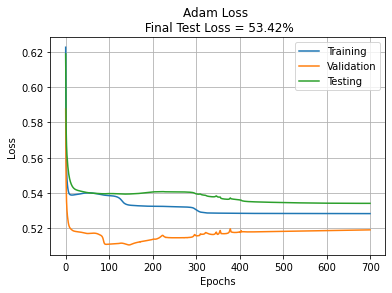

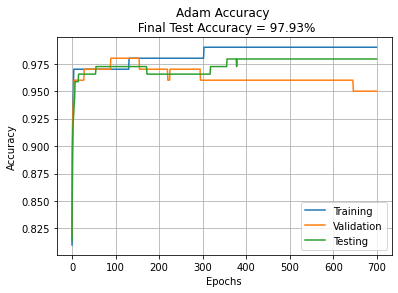

Batch Size = 700


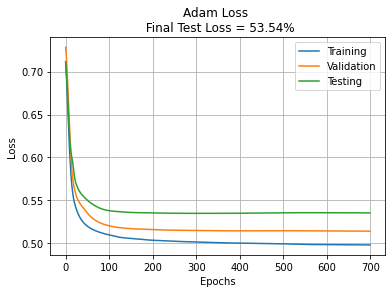

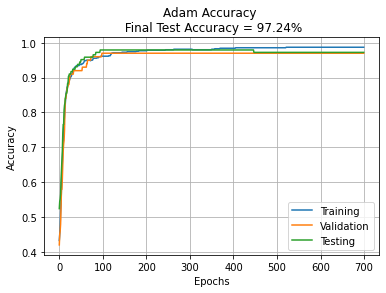

Batch Size = 1750


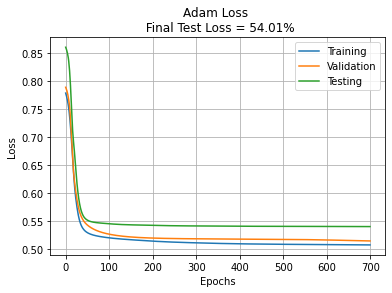

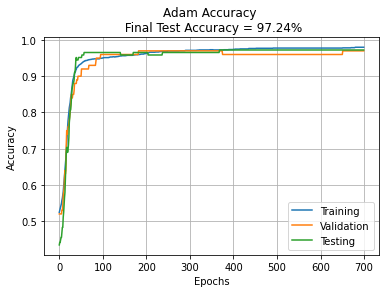

In [100]:
beta1 = None
beta2 = None
epsilon = None
Lambda = 0
alpha = 0.001
epochs = 700
batch_size = [100, 700, 1750]

for batch in batch_size:
  print("Batch Size = %d" %(batch))
  g = buildGraph(beta1, beta2, epsilon, Lambda, alpha, batch, epochs)
  train_model_SGD(g[0], g[1], g[2], g[3], g[4], g[5], g[6], g[7], epsilon, Lambda, alpha, batch, epochs)


### 4. Hyperparameter Investigation

Beta_1 = 0.95


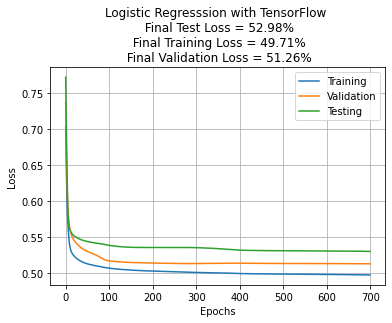

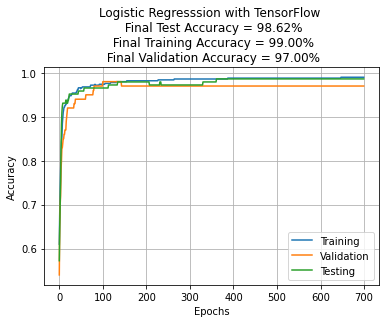

Beta_1 = 0.99


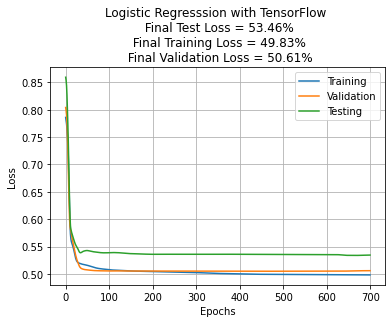

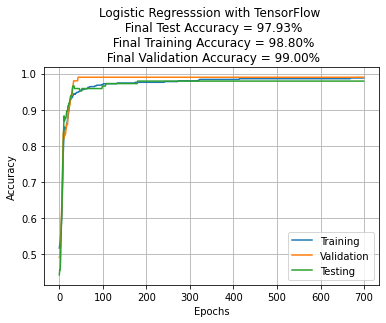

In [25]:
beta1 = [0.95, 0.99]
beta2 = None
epsilon = None
Lambda = 0
alpha = 0.001
epochs = 700
batch_size = 500

for B1 in beta1:
  print("Beta_1 = %.2f" %(B1))
  g = buildGraph(B1, beta2, epsilon, Lambda, alpha, batch_size, epochs)
  train_model_SGD(g[0], g[1], g[2], g[3], g[4], g[5], g[6], g[7], epsilon, Lambda, alpha, batch_size, epochs)

Beta_2  = 0.9900


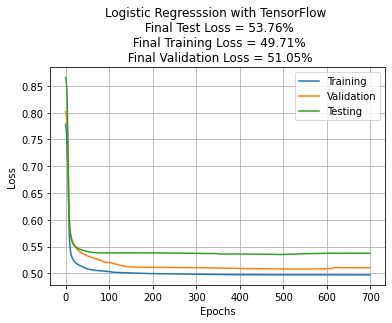

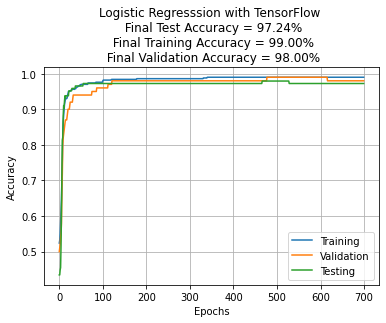

Beta_2  = 0.9999


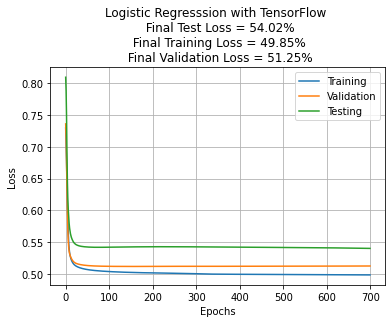

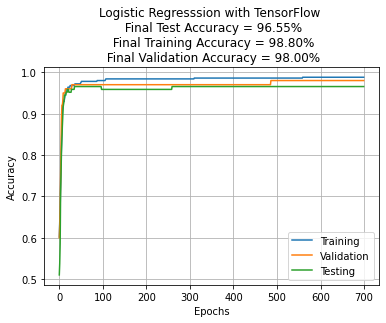

In [27]:
beta1 = None
beta2 = [0.99, 0.9999]
epsilon = None
Lambda = 0
alpha = 0.001
epochs = 700
batch_size = 500

for B2 in beta2:
  print("Beta_2  = %.4f" %(B2))
  g = buildGraph(beta1, B2, epsilon, Lambda, alpha, batch_size, epochs)
  train_model_SGD(g[0], g[1], g[2], g[3], g[4], g[5], g[6], g[7], epsilon, Lambda, alpha, batch_size, epochs)

Epsilon = 0.000000001


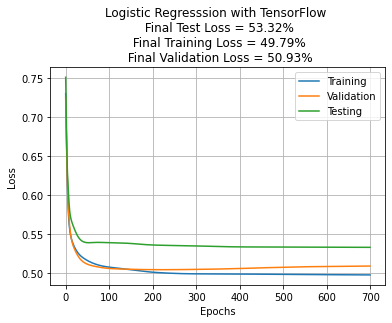

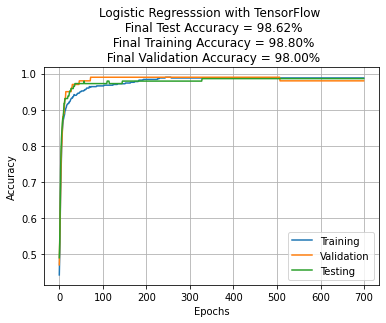

Epsilon = 0.000100000


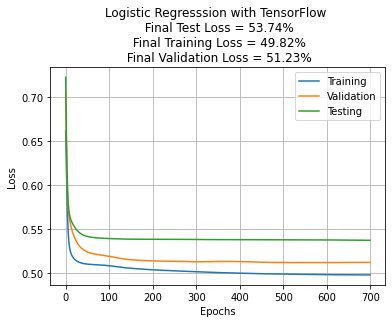

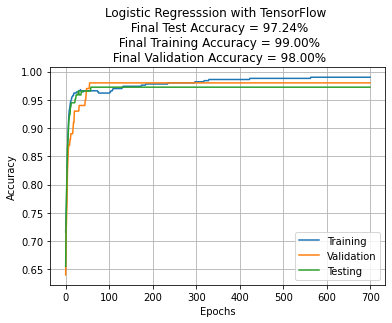

In [29]:
beta1 = None
beta2 = None
epsilon = [1e-9, 1e-4]
Lambda = 0
alpha = 0.001
epochs = 700
batch_size = 500

for ep in epsilon:
  print("Epsilon = %.9f" %(ep))
  g = buildGraph(beta1, beta2, ep, Lambda, alpha, batch_size, epochs)
  train_model_SGD(g[0], g[1], g[2], g[3], g[4], g[5], g[6], g[7], ep, Lambda, alpha, batch_size, epochs)